In [174]:
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

**Aim: For each location in the dataset, find the 5 most locations/tourist destinations based on tourist experience and COVID situation (cases) over the last 90 days.**

In [210]:
random.seed(3888)

# Preparing the data for nearest neighbours analysis

## Data import

In [312]:
df = pd.read_csv("data/data.txt")
df = df.drop(columns='Unnamed: 0')

In [313]:
df_without_covid = df.drop(columns=['new_cases_per_million', 
                                    'new_cases_smoothed_per_million', 
                                    'stringency_index', 
                                    'positive_rate', 
                                    'human_development_index', 
                                    'international_travel_controls',
                                    'cost_living_index',
                                    'date'])

In [314]:
df_without_covid = df_without_covid.drop_duplicates()
df_without_covid = df_without_covid.reset_index()
df_without_covid = df_without_covid.drop(columns=['index'])

df_without_covid

,iso_code,location,continent,tourist_service_index
0,ALB,Albania,Europe,4.01
1,DZA,Algeria,Africa,1.84
2,ARG,Argentina,South America,4.53
3,ARM,Armenia,Asia,4.33
4,AUS,Australia,Oceania,6.06
...,...,...,...,...
111,VEN,Venezuela,South America,2.96
112,VNM,Vietnam,Asia,2.85
113,YEM,Yemen,Asia,1.87
114,ZMB,Zambia,Africa,2.52


In [315]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [316]:
covid_colnames = ['iso_code', 
                  'new_cases_smoothed_per_million',
                  'date'
                 ]

covid_needed_cols = covid[covid_colnames]

In [317]:
covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')

/tmp/ipykernel_2908/1566742333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')


In [318]:
covid_needed_cols = covid_needed_cols[covid_needed_cols['date'] >= datetime.now() - timedelta(days = 90)]

In [319]:
covid_merged = pd.merge(covid_needed_cols, df_without_covid, on="iso_code")

In [320]:
covid_merged

,iso_code,new_cases_smoothed_per_million,date,location,continent,tourist_service_index
0,ALB,494.467,2022-01-28,Albania,Europe,4.01
1,ALB,383.580,2022-01-29,Albania,Europe,4.01
2,ALB,381.442,2022-01-30,Albania,Europe,4.01
3,ALB,520.772,2022-01-31,Albania,Europe,4.01
4,ALB,481.539,2022-02-01,Albania,Europe,4.01
...,...,...,...,...,...,...
10319,ZWE,2.376,2022-04-22,Zimbabwe,Africa,2.95
10320,ZWE,2.717,2022-04-23,Zimbabwe,Africa,2.95
10321,ZWE,2.329,2022-04-24,Zimbabwe,Africa,2.95
10322,ZWE,2.849,2022-04-25,Zimbabwe,Africa,2.95


## Computing medians of quantitative columns

In [321]:
medians = covid_merged.groupby(["iso_code"]).median()

In [322]:
medians = medians.fillna(covid_merged.median())

/tmp/ipykernel_2908/3187006807.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  medians = medians.fillna(covid_merged.median())
/tmp/ipykernel_2908/3187006807.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = medians.fillna(covid_merged.median())


In [323]:
medians

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,23.918,4.01
ARE,36.075,5.63
ARG,115.339,4.53
ARM,31.910,4.33
AUS,1590.472,6.06
...,...,...
VNM,579.879,2.85
YEM,0.052,1.87
ZAF,26.441,4.30


## Min-max scaling

In [324]:
iso_code = medians.index

In [325]:
scaler = MinMaxScaler()

In [326]:
medians_scaled = scaler.fit_transform(medians)

In [327]:
medians_scaled = pd.DataFrame(medians_scaled, 
                              columns = ["new_cases_smoothed_per_million", "tourist_service_index"], 
                              index = iso_code)
medians_scaled

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,0.006194,0.458753
ARE,0.009342,0.784708
ARG,0.029869,0.563380
ARM,0.008264,0.523139
AUS,0.411885,0.871227
...,...,...
VNM,0.150171,0.225352
YEM,0.000013,0.028169
ZAF,0.006847,0.517103


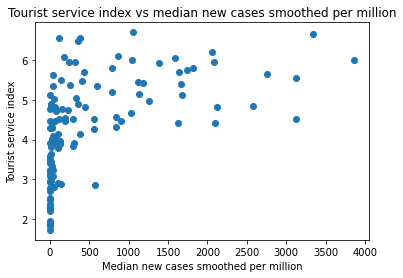

In [328]:
fig, ax = plt.subplots()

scatter = ax.scatter("new_cases_smoothed_per_million", 
                     "tourist_service_index", 
                     data = medians)


plt.title("Tourist service index vs median new cases smoothed per million")
plt.xlabel("Median new cases smoothed per million")
plt.ylabel("Tourist service index")

plt.show()

# Finding 5 nearest neighbours for each location

In [329]:
num_neighbours = 5

In [330]:
nbrs = NearestNeighbors(n_neighbors = num_neighbours + 1, algorithm='ball_tree').fit(medians_scaled)

In [331]:
nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])

In [332]:
iso_location = df[["iso_code", "location"]].drop_duplicates()

In [333]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]

In [334]:
location_neighbours = {}

for i in range(len(nbr_indices)):
    current_iso_code = list(medians_scaled.index)[i]
    current_location = iso_code_to_loc(current_iso_code)
    
    neighbours = []
    for j in range(1, num_neighbours + 1):
        iso_code = medians_scaled.index[nbr_indices[i][j]]
        neighbours.append(iso_code_to_loc(iso_code))
    
    location_neighbours[current_location] = neighbours

In [335]:
location_neighbours_df = pd.DataFrame(location_neighbours).transpose()

In [336]:
location_neighbours_df

,0,1,2,3,4
Albania,Ecuador,Oman,Morocco,Kuwait,Lebanon
United Arab Emirates,Montenegro,Peru,Costa Rica,Bulgaria,Thailand
Argentina,Suriname,Romania,Brazil,Myanmar,Panama
Armenia,South Africa,Ukraine,Myanmar,Suriname,Tunisia
Australia,Luxembourg,Greece,France,New Zealand,Switzerland
...,...,...,...,...,...
Vietnam,Mongolia,Moldova,Iran,Indonesia,Zimbabwe
Yemen,Algeria,Bangladesh,Ethiopia,Cameroon,Nepal
South Africa,Armenia,Ukraine,Myanmar,Suriname,Tunisia
Zambia,Nigeria,Tanzania,Pakistan,Ghana,Rwanda


In [337]:
location_neighbours_df.loc["Australia"]

0     Luxembourg
1         Greece
2         France
3    New Zealand
4    Switzerland
Name: Australia, dtype: object